这是 **工程实践与科技创新Ⅳ-J (CS3507)** 的第一次课程作业，请仔细阅读以下注意事项：

1. 注意作业截止日期，提交作业只需上传 `ipynb` 文件，<font color=red>请务必保留所有单元格的运行结果！</font>
2. 只需在标明 `TODO` 的注释之间补全代码，不要修改其他任何代码（包括导入其他的库等）
3. 本次作业总分 100 分，占总成绩的 15%，其中，代码补全 60 分，后面 3 个问题分别为 10、20、10 分
4. 建议将本文件下载到本地补全并运行

在本次作业中，我们将实现一个简单的二分类感知机。

首先我们生成本次所需的数据分布情况。在绿虚线上方的点标签为 1，下方的点标签为 0，并且增加了小的噪声干扰。

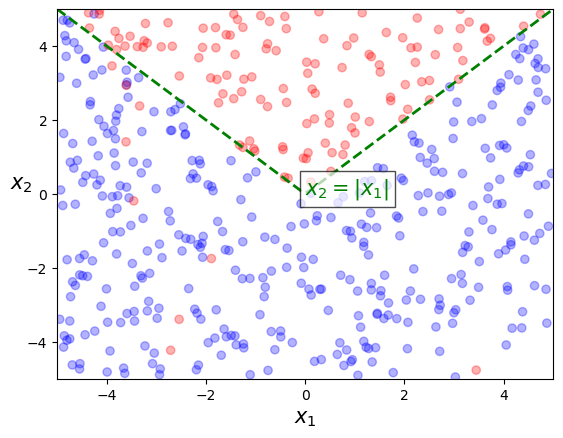

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

seed = 42
random.seed(seed)
np.random.seed(seed)

def generate_data(n_samples=500, x_range=(-5, 5), ratio=0.02):
    """
    生成数据。

    参数：
        n_samples -- 样本数
        x_range -- x的取值范围
        ratio -- 标签翻转比例

    返回：
        X -- 输入数据，形状为 (n_samples, 2)
        label -- 标签，形状为 (n_samples, 1)
    """
    X = np.random.uniform(x_range[0], x_range[1], size=(n_samples, 2))
    boundary = abs(X[:, 0])
    label = np.zeros((n_samples, 1))
    label[X[:, 1] > boundary] = 1
    label[X[:, 1] <= boundary] = 0

    # 随机将 ratio 比例的标签翻转
    flip_index = np.random.choice(n_samples, int(n_samples * ratio), replace=False)
    label[flip_index] = 1 - label[flip_index]

    return X, label

x_range = (-5, 5)
X, label = generate_data(x_range=x_range)

# 可视化
plt.scatter(X[:, 0], X[:, 1], c=label.ravel(), cmap='bwr', alpha=0.3)

x = np.linspace(x_range[0], x_range[1], 100)
plt.plot(x, np.abs(x), 'g--', lw=2)
plt.text(0, 0, r'$x_2 = |x_1|$', fontsize=15, bbox=dict(facecolor='w', alpha=0.7), color='g')

plt.xlim(x_range[0], x_range[1])
plt.ylim(x_range[0], x_range[1])
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15, rotation=0)
plt.show()


一些辅助函数如下所示：

In [3]:
def train_test_split(X, label, test_size=0.2):
    """
    将数据分为训练集和测试集。

    参数：
        X -- 完整的数据集
        label -- 完整的标签
        test_size -- 表示测试集占总数据集的比例

    返回：
        X_train -- 训练集坐标
        X_test -- 测试集坐标
        label_train -- 训练集标签
        label_test -- 测试集标签
    """
    # 计算测试集大小
    total_size = X.shape[0]
    test_size = int(total_size * test_size)

    indices = np.random.permutation(total_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # 分割数据集和标签
    X_train = X[train_indices]
    X_test = X[test_indices]
    label_train = label[train_indices]
    label_test = label[test_indices]

    return X_train, X_test, label_train, label_test


def initialize_parameters(input_dim, hidden_dim, output_dim):
    """
    初始化参数。

    参数：
        input_dim -- 输入层维度
        hidden_dim -- 隐藏层维度
        output_dim -- 输出层维度

    返回：
        W1 -- 权重矩阵，形状为 (input_dim, hidden_dim)
        W2 -- 权重矩阵，形状为 (hidden_dim, output_dim)
    """
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    return W1, W2

对于激活函数，我们选择使用 sigmoid 函数
$$
f(x) = \frac{1}{1+e^{-x}}
$$
函数定义如下：

In [4]:
def sigmoid(X):
    X = np.clip(X, -100, 100) # 防止溢出
    return 1 / (1 + np.exp(-X))

请你计算一下 sigmoid 函数关于 $x$ 的导数，补全下面的函数：

In [5]:
def sigmoid_derivative(X):
    ##############################################
    # TODO
    # 实现 sigmoid 函数的导数
    ##############################################
    
    d_sigmoid = sigmoid(X) * (1 - sigmoid(X))       # f(x)*(1-f(x))

    ##############################################
    # 结束您的代码
    ##############################################
    return d_sigmoid

下面依次实现：前向传播、反向传播、损失函数。

首先是前向传播，整个过程大致如下：

$$
\verb|X|\xrightarrow{\verb|W1|}\verb|hidden|'\xrightarrow{\verb|sigmoid|}\verb|hidden|\xrightarrow{\verb|W2|}\verb|label|'\xrightarrow{\verb|sigmoid|}\verb|label|
$$

In [6]:
def two_layer_perceptron(X, W1, W2):
    """
    两层感知机的前向传播过程。

    参数：
        X -- 输入数据，形状为 (n_samples, input_dim)
        W1 -- 第一层的权重矩阵，形状为 (input_dim, hidden_dim)
        W2 -- 第二层的权重矩阵，形状为 (hidden_dim, output_dim)

    返回：
        hidden_layer -- 隐藏层输出，形状为 (n_samples, hidden_dim)
        label_pred -- 输出，形状为 (n_samples, output_dim)
    """
    ##############################################
    # TODO
    # 实现两层感知机的前向传播过程
    ##############################################

    hidden_layer = sigmoid(np.dot(X, W1))           # (n_samples, hidden_dim) = (n_samples, input_dim)·(input_dim, hidden_dim)
    label_pred = sigmoid(np.dot(hidden_layer, W2))  # (n_samples, output_dim) = (n_samples, hidden_dim)·(hidden_dim, output_dim)

    ##############################################
    # 结束您的代码
    ##############################################
    return hidden_layer, label_pred

接下来实现反向传播过程，即利用链式法则求出 `W1` `W2` 的梯度，为后续的参数更新做准备。

输出层：
$$
\frac{\partial E}{\partial W_{jk}} = \delta ^{(2)}_k O_j \\
\delta ^{(2)}_k = sigmoid'(O_k)(O_k - target_k) 
$$

隐藏层：
$$
\frac{\partial E}{\partial W_{ij}} = \delta ^{(1)}_j O_i \\
\delta ^{(1)}_j = sigmoid'(O_j)\sum _k \delta ^{(2)}_k w_{jk} 
$$

In [7]:
def two_layer_perceptron_backward(X, label_true, label_pred, hidden_layer, W1, W2):
    """
    两层感知机的反向传播算法。

    参数：
        X -- 输入数据，形状为 (n_samples, input_dim)
        label_true -- 真实标签，形状为 (n_samples, output_dim)
        label_pred -- 预测标签，形状为 (n_samples, output_dim)
        hidden_layer -- 隐藏层输出，形状为 (n_samples, hidden_dim)
        W1 -- 第一层的权重矩阵，形状为 (input_dim, hidden_dim)
        W2 -- 第二层的权重矩阵，形状为 (hidden_dim, output_dim)

    返回：
        grads -- 包含梯度的字典
    """
    ##############################################
    # TODO
    # 实现两层感知机的反向传播算法
    # 提示：计算输出层梯度，然后反向传播到隐藏层，最后计算输入层到隐藏层的权重梯度
    ##############################################

    delta_W2 = sigmoid_derivative(label_pred) * (label_pred - label_true) # (n_samples, output_dim)

    d_W2 = np.dot(hidden_layer.T, delta_W2) # (hidden_dim, output_dim) = (hidden_dim, n_samples)·(n_samples, output_dim)

    delta_W1 = sigmoid_derivative(hidden_layer) * np.dot(delta_W2, W2.T) # (n_samples, hidden_dim) = (n_samples, output_dim)·(output_dim, hidden_dim)

    d_W1 = np.dot(X.T, delta_W1) # (input_dim, hidden_dim) = (input_dim, n_samples)·(n_samples, hidden_dim)

    ##############################################
    # 结束您的代码
    ##############################################

    grads = {'W1': d_W1, 'W2': d_W2} # 封装 W1 W2 的梯度 d_W1 d_W2 到字典
    return grads

我们再来实现交叉熵损失函数，它是分类问题最常用到的损失函数之一，一条样本 $k$ 的交叉熵损失定义为如下形式：

$$
\verb|loss|_k = -\sum\limits_{i=\verb|1|}^{\verb|C|}{\verb|label_true|_i}\cdot\log{\verb|label_pred|_i}\quad k = 1,2,\cdots,\verb|n_samples| \\
其中，C表示类别的总数。
$$


In [8]:
def cross_entropy_loss(label_pred, label_true):
    """
    计算所有样本的平均交叉熵损失。

    参数：
        label_pred -- 预测标签，形状为 (n_samples, 1)
        label_true -- 真实标签，形状为 (n_samples, 1)

    返回：
        loss -- 平均交叉熵损失
    """

    n_samples = label_true.shape[0]
    label_pred = np.clip(label_pred, 1e-9, 1 - 1e-9) # 避免数值不稳定

    ##############################################
    # TODO
    # 实现交叉熵损失函数
    ##############################################

    loss = np.dot(label_true.T, np.log(label_pred))[0] * (-1) / n_samples

    ##############################################
    # 结束您的代码
    ##############################################
    return loss


我们已实现完成所有需要的“部件”，接下来将它们组装为训练过程的函数。

In [9]:
def train(X, label_true, epochs=2000, learning_rate=0.001):
    """
    训练感知机模型。

    参数：
        X -- 输入数据，形状为 (n_samples, input_dim)
        label_true -- 真实标签，形状为 (n_samples, 1)
        epochs -- 训练迭代次数
        learning_rate -- 学习率

    返回：
        W1 -- 第一层的权重矩阵，形状为 (input_dim, hidden_dim)
        W2 -- 第二层的权重矩阵，形状为 (hidden_dim, output_dim)
        losses -- 训练损失列表
    """
    input_dim = X.shape[1]
    hidden_dim = 64
    output_dim = 1

    # 初始化权重
    W1, W2 = initialize_parameters(input_dim, hidden_dim, output_dim)

    # 训练循环
    losses = []
    for i in range(epochs):
        ##############################################
        # TODO
        # 实现感知机的一次迭代过程
        ##############################################
        # 前向传播
        hidden_layer, label_pred = two_layer_perceptron(X, W1, W2)

        # 计算损失
        losses.append(cross_entropy_loss(label_pred, label_true))

        # 反向传播
        grads = two_layer_perceptron_backward(X, label_true, label_pred, hidden_layer, W1, W2)

        # 参数更新
        W1 -= learning_rate * grads['W1']
        W2 -= learning_rate * grads['W2']

        ##############################################
        # 结束您的代码
        ##############################################

    return W1, W2, losses

下面是测试模型性能的函数：

In [10]:
def test(X, label_true, W1, W2):
    """
    测试感知机模型。

    参数：
        X -- 输入数据，形状为 (n_samples, input_dim)
        label_true -- 标签，形状为 (n_samples, 1)
        W1 -- 第一层的权重矩阵，形状为 (input_dim, hidden_dim)
        W2 -- 第二层的权重矩阵，形状为 (hidden_dim, output_dim)

    返回：
        accuracy -- 准确率
    """
    _, label_pred = two_layer_perceptron(X, W1, W2)
    label_pred = (label_pred > 0.5).astype(int)
    accuracy = np.mean(label_pred == label_true)
    return accuracy

大功即将告成，我们来看看你实现的感知机的效果如何吧。

Test accuracy: 0.9625


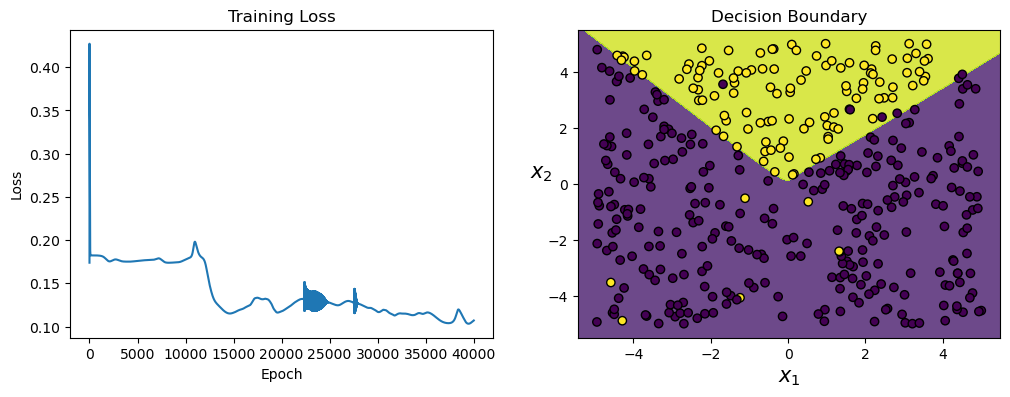

In [18]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# 超参数设置
##############################################
# TODO
# 设置超参数
# 提示：你可以调整以下超参数，以达到你比较满意的结果
##############################################
epochs = 40000
learning_rate = 0.001
##############################################
# 结束您的代码
##############################################

# 准备数据
n_samples = 2000
ratio = 0.02
x_range = (-5, 5)
X, label = generate_data(n_samples=n_samples, x_range=x_range, ratio=ratio)
X_train, X_test, label_train, label_test = train_test_split(X, label)

# 训练模型
W1, W2, losses = train(X_train, label_train, epochs=epochs, learning_rate=learning_rate)

# 评估模型
accuracy = test(X_test, label_test, W1, W2)
print(f"Test accuracy: {accuracy}")

# 绘制损失曲线
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axs[0].plot(losses)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# 绘制决策边界
def plot_decision_boundary(X, label, model):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    _, Z = model(np.c_[xx.ravel(), yy.ravel()], W1, W2)
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    axs[1].contourf(xx, yy, Z, alpha=0.8)
    axs[1].scatter(X[:, 0], X[:, 1], c=label.ravel(), edgecolors='black')
    axs[1].set_title('Decision Boundary')
    axs[1].set_xlabel(r'$x_1$', fontsize=15)
    axs[1].set_ylabel(r'$x_2$', fontsize=15, rotation=0)

plot_decision_boundary(X_test, label_test, lambda X, W1, W2: two_layer_perceptron(X, W1, W2))
plt.show()


最后，有 3 个小问题，请你认真探索和思考后回答一下吧。

**问题 1**：在调整超参的过程中，你有观察到什么有意思的现象吗？（例如，`epochs` 太少或太多、`learning_rate` 太小或太大）

**回答 1**：
+ 如果`epochs`太小，模型会欠拟合；如果`epochs`太大，模型会过拟合。
+ 如果`learning_rate`太小，模型收敛太慢，且容易困于局部最优解；如果`learning_rate`太大，loss振动幅度较大，模型难以收敛。

**问题 2**：如果在产生数据的过程中，将标签打乱的比例 `ratio` 增加到 `0.05`，其余超参都不变，会导致什么？此时 `epochs` 和 `learning_rate` 该如何调整？如果样本量 `n_samples` 可以增减，实验效果又会如何变化？

（你可以在下面的单元格中多试一试）

Test accuracy: 0.92


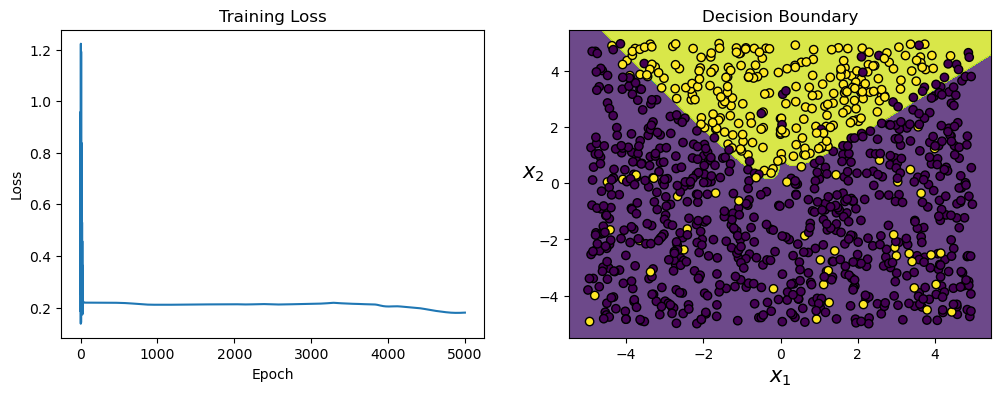

In [25]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# 超参数设置
##############################################
# TODO
# 设置超参数
# 提示：你可以调整以下超参数，以达到你比较满意的结果
##############################################
epochs = 5000
learning_rate = 0.001
n_samples = 5000
##############################################
# 结束您的代码
##############################################

# 准备数据
ratio = 0.05
x_range = (-5, 5)
X, label = generate_data(n_samples=n_samples, x_range=x_range, ratio=ratio)
X_train, X_test, label_train, label_test = train_test_split(X, label)

# 训练模型
W1, W2, losses = train(X_train, label_train, epochs=epochs, learning_rate=learning_rate)

# 评估模型
accuracy = test(X_test, label_test, W1, W2)
print(f"Test accuracy: {accuracy}")

# 绘制损失曲线
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axs[0].plot(losses)
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# 绘制决策边界
plot_decision_boundary(X_test, label_test, lambda X, W1, W2: two_layer_perceptron(X, W1, W2))
plt.show()


**回答 2**：
+ 改变`ratio`后，模型精确度下降，通过Training Loss图可以看到`epochs`为25000左右loss比较小。
+ 减少`epochs`到25000，模型精确度变高，说明`epochs`过大会导致模型过拟合。
+ 增加`n_samples`的同时要减少`epochs`，否则模型会过拟合。
+ 如果`learning_rate`太小，模型收敛太慢，且容易困于局部最优解；如果`learning_rate`太大，loss振动幅度较大，模型难以收敛。

**问题 3**：你觉得我们实现的感知机的缺点有哪些？有哪些改进措施？


**回答 3**：
+ 收敛较慢，训练时间较长。可尝试减少隐藏层维数。
+ 可在隐藏层内增加`bias`。
+ 可尝试其他激活函数。
